In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [9]:
from torch import tensor
import matplotlib.pyplot as plt

from mvl2.pyro import model, run
from mvl2 import genData2


In [10]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    # "PD_both": tensor(.005),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)


/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


In [11]:
sim_data["PVDs"].mean(0)

tensor([9.9243e-05, 1.2890e-04, 1.1543e-04, 1.5582e-04], dtype=torch.float64)

In [12]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([9.9997e-05, 9.9997e-05, 9.9997e-05, 9.9997e-05], dtype=torch.float64)
mean affects 1 tensor([9.8561e-05, 9.9584e-05, 1.9878e-04, 1.9878e-04], dtype=torch.float64)
std affects 1 tensor([9.6903e-05, 9.7906e-05, 1.9582e-04, 1.9582e-04], dtype=torch.float64)
mean affects 2 tensor([9.4720e-05, 3.0142e-04, 2.0108e-04, 6.2627e-04], dtype=torch.float64)
std affects 2 tensor([8.9165e-05, 2.9972e-04, 1.9943e-04, 6.6947e-04], dtype=torch.float64)
mean affects 3 tensor([9.6495e-05, 2.9600e-04, 9.8530e-05, 2.9600e-04], dtype=torch.float64)
std affects 3 tensor([0.0001, 0.0003, 0.0001, 0.0003], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


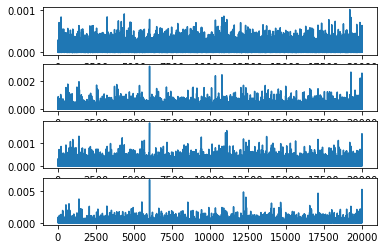

In [13]:
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [14]:
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/project/mvl2/genData2.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


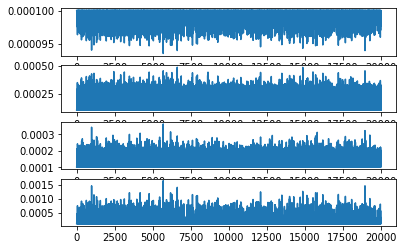

In [15]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [16]:
run_params = {
    "data": sim_data_point_pv["alt_counts"],
    "n_cases": sim_params_point_pv["n_cases"],
    "n_ctrls": sim_params_point_pv["n_ctrls"],
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 12,
    "chain_method": 'parallel',
    "model_to_run": model,
}


In [17]:
sim_params_point_pv["n_cases"] / (sim_params_point_pv["n_cases"].sum() + sim_params_point_pv["n_ctrls"])

tensor([0.1786, 0.1786, 0.0476])

In [24]:
from typing import Any, Tuple, Optional

import datetime
import os
import copy
import multiprocessing
import uuid

import torch
import numpy as np
import dill

import pyro
from pyro.distributions import Exponential
from pyro.distributions.torch import Multinomial, Beta, Dirichlet, Beta, Categorical, MultivariateNormal, Uniform#, Exponential #, HalfCauchy, LKJCholesky
from pyro.infer import TraceEnum_ELBO, TraceGraph_ELBO, MCMC, NUTS, TraceGraph_ELBO, config_enumerate#, #HMCECS, MixedHMC
from torch import tensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiscreteParallel
import pyro.poutine as poutine

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(0)

def set_platform(platform: str = "cpu") -> None:
    pyro.set_platform(platform)

def get_pdhat(n_cases: tensor, n_ctrls: int):
    samplePDs = n_cases.float() / (n_cases.float().sum() + float(n_ctrls))
    return tensor([1.0 - samplePDs.sum(), *samplePDs])


def get_expected_K(sampleCategories: int):
    # mu_exp, var_exp = get_log_params(liabParams55cov["afMean"].numpy(), 1)
    # Expected number of components
    # For 2 case types it's
    # none, 1only, 2only, both
    # For 3 it's
    # none, 1only, 2only, 3only, 1&2, 1&3, 2&3, 123 (7)
    # for 4 it's
    # none, 1only, 2only, 3only, 4only, 1&2, 1&3, 1&4, 2&3, 2&4, 3&4, 123, 124, 134, 234, 1234
    # which is 4 + 4choose2 + nchoose3  + nchoose4
    pass


def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

# Covariates needed
# Sex of the individual
# parent of origin would be important
def model1(data, n_cases: tensor, n_ctrls: tensor, k_hypotheses: tensor, alpha: float = .05):
    with pyro.plate("beta_plate", k_hypotheses-1):
        beta = pyro.sample("beta", Beta(1, alpha / k_hypotheses))

    pd_hat = get_pdhat(n_cases, n_ctrls)
    with pyro.plate("prob_plate", k_hypotheses):
        probs = pyro.sample("probs", Dirichlet(pd_hat))

    with pyro.plate("data", data.shape[0]):
        z = pyro.sample("z", Categorical(mix_weights(beta)), infer={"enumerate": "sequential"})
        return pyro.sample("obs", Multinomial(probs=probs[z], validate_args=False), obs=data)

def run1(run_params, folder_prefix: str = "") -> Tuple[MCMC, Tuple]:
    # mcmc = infer(**run_params)
    optim = Adam({"lr": 0.05})
    guide = AutoDelta(poutine.block(model1, hide=['z']))

    svi = SVI(model1, guide, optim, loss=TraceEnum_ELBO())
    losses = []
    def train(num_iterations):
        pyro.clear_param_store()
        for j in tqdm(range(num_iterations)):
            loss = svi.step(run_params['data'], run_params['n_cases'].float(), run_params['n_ctrls'].float(), run_params['max_K'])
            losses.append(loss)

    # def truncate(alpha, weights):
    #     threshold = alpha**-1 / 100.
    #     # true_centers = centers[weights > threshold]
    #     true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    #     return true_weights

    # alpha = 0.1
    train(1000)
    return losses, svi

In [23]:
losses, svi = run1(run_params=run_params)

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'float'

In [102]:
max(losses)

133410.9375

In [16]:
mcmc, inferred_params = run(sim_data=sim_data_point_pv, run_params=run_params)

NameError: name 'numpyro' is not defined

In [14]:
data = run_params['data']
n_cases = run_params['n_cases']
n_ctrls = run_params['n_ctrls']
max_K = run_params['max_K']

guide = AutoNormal(model)
svi = SVI(model, guide, optim.Adam(0.01), TraceGraph_ELBO())
svi_state = svi.init(random.PRNGKey(0), data, n_cases, n_ctrls, max_K)
svi_result = svi.run(random.PRNGKey(1), 1000)
guide_samples = guide.sample_posterior(random.PRNGKey(2), svi_result.params)
guide_samples

ValueError: Continuous inference cannot handle discrete sample site 'z'.